# Instant Recognition with Caffe

Erkennung und Visualisierung von Netzen, die mit dem cifar10-Set oder einem sub-Set trainiert wurden.

(Lenny's adaption)

(These feature visualizations follow the DeCAF visualizations originally by Yangqing Jia.)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Make sure that caffe is on the python path:
caffe_root = '../../'  # this file is expected to be in {caffe_root}/examples
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import os


Set Caffe to CPU mode, load the net in the test phase for inference, and configure input preprocessing.

In [3]:
caffe.set_mode_cpu()
net = caffe.Net(caffe_root + 'networks/conv_net_3/run_2/network/deploy.prototxt',
                caffe_root + 'networks/conv_net_3/run_2/snapshots/_iter_5000.caffemodel',
                caffe.TEST)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.load(caffe_root + 'data/cifar10/training/categories_4/FDAA/mean.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

Let's start with a simple classification. We'll set a batch of 50 to demonstrate batch processing, even though we'll only be classifying one image. (Note that the batch size can also be changed on-the-fly.)

In [4]:
# set net to batch size of 50
net.blobs['data'].reshape(50,3,32,32)

Feed in the image (with some preprocessing) and classify with a forward pass.

In [5]:
net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(caffe_root + 'data/cifar10/all_images/test/frog/frog_3.png'))
out = net.forward()
print("Predicted class is #{}.".format(out['prob'].argmax()))

Predicted class is #0.


What did the input look like?

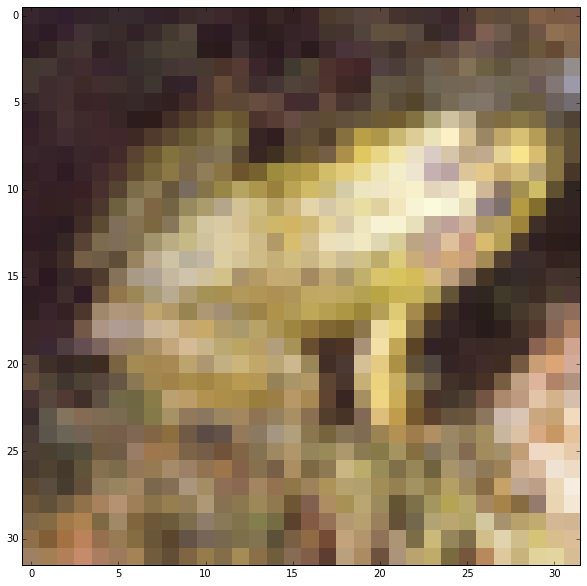

In [6]:
plt.imshow(transformer.deprocess('data', net.blobs['data'].data[0]))

Adorable, but was our classification correct?

In [7]:
# load labels
imagenet_labels_filename = caffe_root + 'data/cifar10/training/categories_4/FDAA/label_map.txt'

labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')

# sort top k predictions from softmax output
top_k = net.blobs['prob'].data[0].flatten().argsort()[-1:-6:-1]
print labels[top_k]

['0 frog' '3 automobile' '1 deer' '2 airplane']


Indeed! But how long did it take?

In [8]:
# CPU mode
net.forward()  # call once for allocation
%timeit net.forward()

1 loops, best of 3: 317 ms per loop


That's a while, even for a batch size of 50 images. Let's switch to GPU mode.

In [9]:
[(k, v.data.shape) for k, v in net.blobs.items()]

[('data', (50, 3, 32, 32)),
 ('conv1', (50, 32, 32, 32)),
 ('pool1', (50, 32, 16, 16)),
 ('ip1', (50, 3072)),
 ('ip2', (50, 4)),
 ('prob', (50, 4))]

The parameters and their shapes. The parameters are `net.params['name'][0]` while biases are `net.params['name'][1]`.

In [10]:
[(k, v[0].data.shape) for k, v in net.params.items()]

[('conv1', (32, 3, 5, 5)), ('ip1', (3072, 8192)), ('ip2', (4, 3072))]

Helper functions for visualization

In [11]:
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)

The first fully connected layer, `ip1` (rectified)

We show the output values and the histogram of the positive values

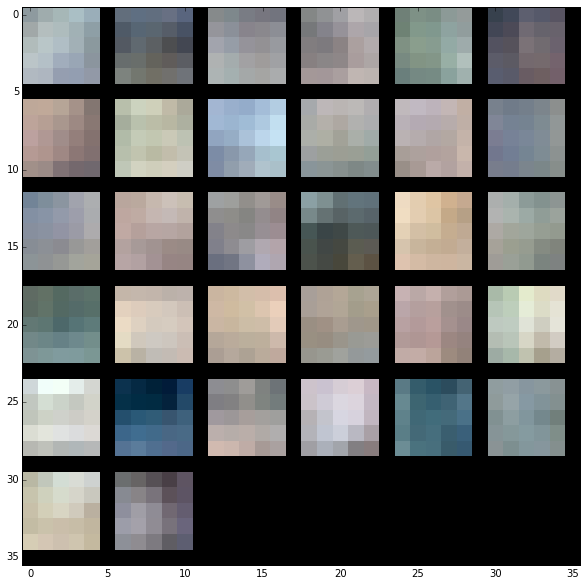

In [12]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

The first layer output, conv1 (rectified responses of the filters above, first 36 only)

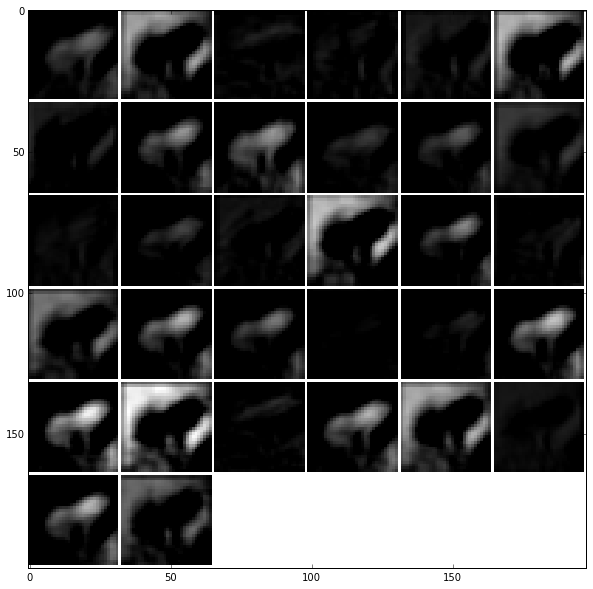

In [13]:
feat = net.blobs['conv1'].data[0, :36]
vis_square(feat, padval=1)

Layer after pooling

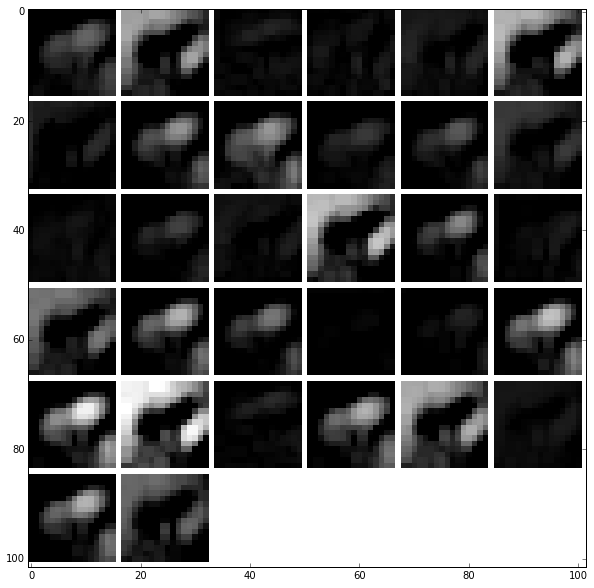

In [18]:
feat = net.blobs['pool1'].data[0]
vis_square(feat, padval=1)

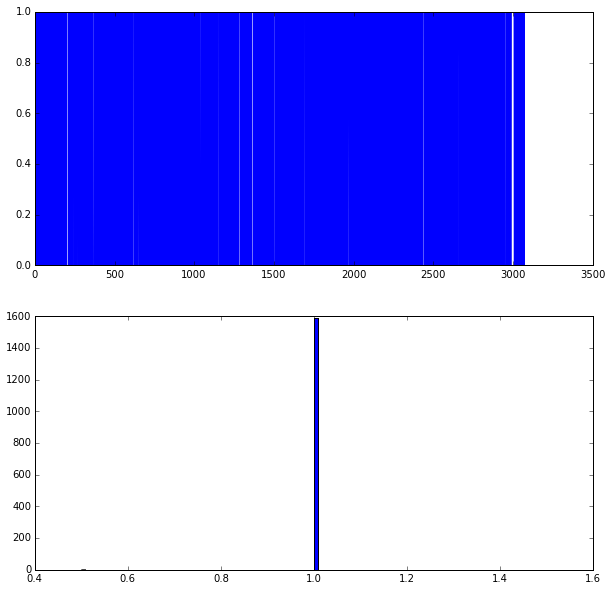

In [14]:
feat = net.blobs['ip1'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

The final probability output, `prob`

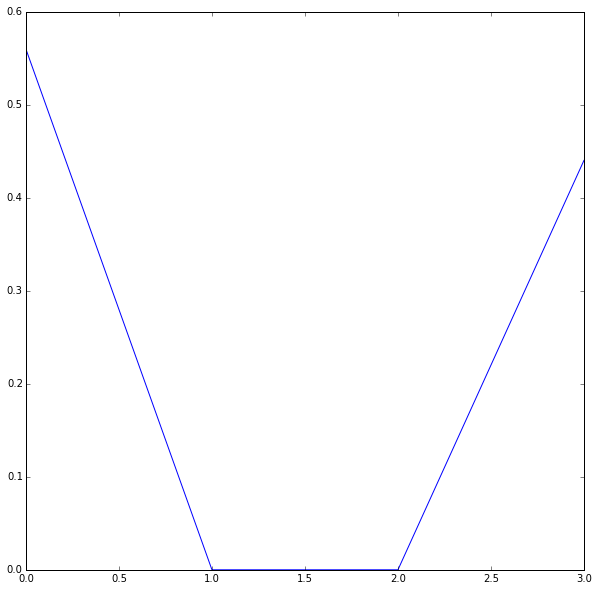

In [15]:
feat = net.blobs['prob'].data[0]
plt.plot(feat.flat)